<a href="https://colab.research.google.com/github/AsifShaafi/Deep-Learning-Course-Examples/blob/main/ML_Examples/function_Shaafi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Function Approximation using TensorFlow v2

Creating a neural network with 2 hidden layers to approximate one function:

- $f_2(x_1,x_2) = \cos{\left(x_1\right)} + \sqrt{x_1^2 + x_2^2}$

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import tensorflow as tf
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

print(f"Using TensorFlow {tf.__version__}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

Using TensorFlow 2.15.0
Num GPUs Available: 0


In [2]:
# Define the function to be approximated
def func(x1, x2): return np.cos(x1) + np.sqrt(x1**2 + x2**2)


In [3]:
# Method to generate data
def generate_data(func, mg_dims=(500,500), ratio=0.8):
    """ Generates a training and test data set for the model to
        train on.
    """
    # create meshgrid and calculate y-values
    x1_vals=np.linspace(-10, 10, mg_dims[0])
    x2_vals=np.linspace(-10, 10, mg_dims[1])
    x1,x2 = np.meshgrid(x1_vals, x2_vals)
    f = func(x1, x2)

    # reshape the data
    x_data = np.vstack([x1.flatten(), x2.flatten()]).transpose()
    y_data = f.flatten()

    # shuffle the data
    rand_idcs = np.random.permutation(len(x_data))
    x_data = x_data[rand_idcs]
    y_data = y_data[rand_idcs]

    # split the data into training and test sets
    num_train = round(reduce(lambda dim1,dim2: dim1*dim2, mg_dims)*ratio)

    x_train = x_data[:num_train]
    y_train = y_data[:num_train]

    x_test = x_data[num_train:]
    y_test = y_data[num_train:]

    return (x_train, y_train), (x_test, y_test)

# visualization tool
def plot_func(func, x1_vals=np.linspace(-10,10,100), x2_vals=np.linspace(-10,10,100)):
    """ Plots a contour map and 3D surface plot of a given two-variable function
        over the domain -10 <= x1,x2 <= 10
    """
    # make meshgrid and calculate outputs
    x1,x2 = np.meshgrid(x1_vals, x2_vals)
    f = func(x1, x2)

    # set up figure
    fig = plt.figure(figsize=(14,6))
    plt.suptitle('Contour and Surface Plots of $f(x_1,x_2)$', fontsize=16)

    # first subplot is a contour plot
    ax = fig.add_subplot(1, 2, 1)
    cont = ax.contourf(x1,x2,f)
    ax.set_xlabel('$x_1$', fontsize=16)
    ax.set_ylabel('$x_2$', fontsize=16)

    # second subplot is a surface plot
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    surf = ax.plot_surface(x1, x2, f, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_xlabel('$x_1$', fontsize=16)
    ax.set_ylabel('$x_2$', fontsize=16)
    ax.set_zticks([])
    fig.colorbar(surf, shrink=0.5, aspect=10)

    plt.show()

def plot_approx(model, x1_vals=np.linspace(-10,10,100), x2_vals=np.linspace(-10,10,100)):
    """ Plots a contour map and 3D surface plot of the approximation of a function
        by a simple neural network (model) over the domain -10 <= x1,x2 <= 10
    """
    # make meshgrid and calculate outputs
    x1,x2 = np.meshgrid(x1_vals, x2_vals)
    x_data = np.vstack([x1.flatten(), x2.flatten()]).transpose()
    f = model.predict(x_data).reshape(x1.shape)

    # set up figure
    fig = plt.figure(figsize=(14,6))
    plt.suptitle("Contour and Surface Plots of Model's Approximation", fontsize=16)

    # first subplot is a contour plot
    ax = fig.add_subplot(1, 2, 1)
    cont = ax.contourf(x1,x2,f)
    ax.set_xlabel('$x_1$', fontsize=16)
    ax.set_ylabel('$x_2$', fontsize=16)

    # second subplot is a surface plot
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    surf = ax.plot_surface(x1, x2, f, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_xlabel('$x_1$', fontsize=16)
    ax.set_ylabel('$x_2$', fontsize=16)
    ax.set_zticks([])
    fig.colorbar(surf, shrink=0.5, aspect=10)

    plt.show()


In [4]:
# generate the training and test data using the original function
(x_train, y_train), (x_test, y_test) = generate_data(func)

# print(f"Training data shape: {x_train.shape}")

# clear session of any previous models
clear_session()

# create function approximation model
n_hidden = 200
model = Sequential([
    Dense(n_hidden, input_shape=(x_train.shape[1],), activation='relu'),
    Dense(100, activation='relu'),
    Dense(1)
])

# make loss function and optimizer and compile the model
loss_function = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-2)
model.compile(optimizer=optimizer, loss=loss_function, metrics=['mean_absolute_error'])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               600       
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 20801 (81.25 KB)
Trainable params: 20801 (81.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Fit the model to the training data:

In [6]:
%%time
history = model.fit(x_train, y_train, epochs=30, batch_size=500, verbose=0)

CPU times: user 39.2 s, sys: 2.27 s, total: 41.4 s
Wall time: 42.1 s


In [7]:
# evaluate the model using the test data
model.evaluate(x_test, y_test, verbose=1)

1563/1563 [==============================] - 2s 999us/step - loss: 9.9548e-04 - mean_absolute_error: 0.0239


[0.0009954794077202678, 0.02391776815056801]

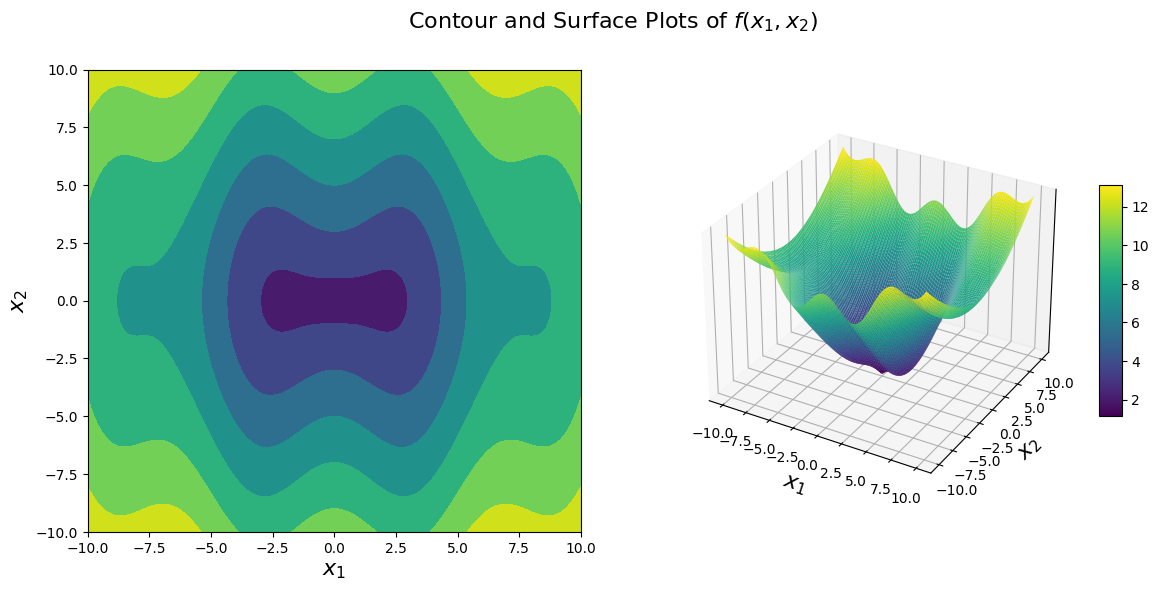

313/313 [==============================] - 0s 1ms/step


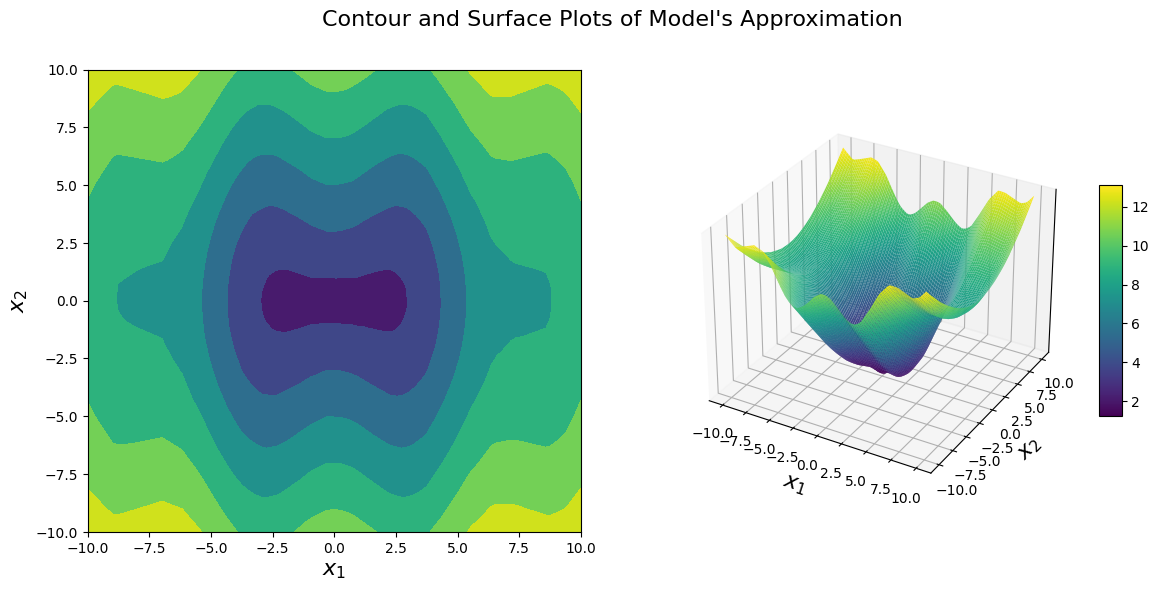

In [8]:
# plot the original function and the approximation by the model
plot_func(func)
plot_approx(model)